<a href="https://colab.research.google.com/github/addyj/END_Merger/blob/main/5.RNNs%20renewed%20relevance/RNN-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [47]:
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')

# Read and process data. 

Download the file from this URL: https://drive.google.com/file/d/1UWWIi-sz9g0x3LFvkIZjvK1r2ZaCqgGS/view?usp=sharing

In [48]:
import requests
textFile = 'https://raw.githubusercontent.com/addyj/END_Merger/main/5.RNNs%20renewed%20relevance/assets/text.txt'
req = requests.get(textFile)
data = req.text
#data = open('https://raw.githubusercontent.com/gkdivya/NLP_Notebooks/main/5%20-%20RNNs/assets/text.txt', 'r').read()


Process data and calculate indices

In [49]:
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("Corona Virus article has %d characters, %d unique characters" %(data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

Corona Virus article has 10224 characters, 75 unique characters


# Constants and Hyperparameters

In [50]:
Hidden_Layer_size = 100 #size of the hidden layer
Time_steps = 40 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning Rate
weight_sd = 0.1 #Standard deviation of weights for initialization
z_size = Hidden_Layer_size + X_size #Size of concatenation(H, X) vector

# Activation Functions and Derivatives

In [51]:
def sigmoid(x): # sigmoid function
  return 1 / (1 + np.exp(-x))

def dsigmoid(y): # derivative of sigmoid function
  return y * (1 - y)

def tanh(x): # tanh function
  return np.tanh(x)

def dtanh(y): # derivative of tanh
  return 1 - y * y

In [52]:
print(f"Quiz Question 1: {(sigmoid(0)):.1f}")
print(f"Quiz Question 2: {(dsigmoid(sigmoid(0))):.2f}")
print(f"Quiz Question 3: {tanh(dsigmoid(sigmoid(0))):.5f}")
print(f"Quiz Question 4:  {dtanh(tanh(dsigmoid(sigmoid(0)))):.5f}")

Quiz Question 1: 0.5
Quiz Question 2: 0.25
Quiz Question 3: 0.24492
Quiz Question 4:  0.94001


# Quiz Question 1

What is the value of sigmoid(0) calculated from  your code? (Answer up to 1 decimal point, e.g. 4.2 and NOT 4.29999999, no rounding off).

# Quiz Question 2

What is the value of dsigmoid(sigmoid(0)) calculated from your code?? (Answer up to 2 decimal point, e.g. 4.29 and NOT 4.29999999, no rounding off). 

# Quiz Question 3

What is the value of tanh(dsigmoid(sigmoid(0))) calculated from your code?? (Answer up to 5 decimal point, e.g. 4.29999 and NOT 4.29999999, no rounding off).

# Quiz Question 4

What is the value of dtanh(tanh(dsigmoid(sigmoid(0)))) calculated from your code?? (Answer up to 5 decimal point, e.g. 4.29999 and NOT 4.29999999, no rounding off).

# Parameters

In [53]:
class Param:
    def __init__(self, name, value):
      self.name = name
      self.v = value # parameter value
      self.d = np.zeros_like(value) # derivative
      self.m = np.zeros_like(value) # momentum for Adagrad

We use random weights with normal distribution (0, weight_sd) for  tanh  activation function and (0.5, weight_sd) for  `sigmoid`  activation function.

Biases are initialized to zeros.

# LSTM 
You are making this network, please note f, i, c and o (also "v") in the image below:
![alt text](http://blog.varunajayasiri.com/ml/lstm.svg)

Please note that we are concatenating the old_hidden_vector and new_input.

# Quiz Question 4

In the class definition below, what should be size_a, size_b, and size_c? ONLY use the variables defined above.

In [54]:
size_a = Hidden_Layer_size #Hidden Layers size 
size_b =  z_size # Size of concatenate(H, X) vector
size_c = X_size # Number of characters

class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', np.random.randn(size_a, size_b) * weight_sd + 0.5)
        self.b_f = Param('b_f', np.zeros((size_a, 1)))

        self.W_i = Param('W_i', np.random.randn(size_a, size_b) * weight_sd + 0.5)
        self.b_i = Param('b_i', np.zeros((size_a, 1)))

        self.W_C = Param('W_C', np.random.randn(size_a, size_b) * weight_sd)
        self.b_C = Param('b_C', np.zeros((size_a, 1)))

        self.W_o = Param('W_o', np.random.randn(size_a, size_b) * weight_sd + 0.5)
        self.b_o = Param('b_o', np.zeros((size_a, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v', np.random.randn(X_size, size_a) * weight_sd)
        self.b_v = Param('b_v', np.zeros((size_c, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

Look at these operations which we'll be writing:

**Concatenation of h and x:**

$z\:=\:\left[h_{t-1},\:x\right]$

$f_t=\sigma\left(W_f\cdot z\:+\:b_f\:\right)$

$i_i=\sigma\left(W_i\cdot z\:+\:b_i\right)$

$\overline{C_t}=\tanh\left(W_C\cdot z\:+\:b_C\right)$

$C_t=f_t\ast C_{t-1}+i_t\ast \overline{C}_t$

$o_t=\sigma\left(W_o\cdot z\:+\:b_i\right)$

$h_t=o_t\ast\tanh\left(C_t\right)$

**Logits:**

$v_t=W_v\cdot h_t+b_v$

**Softmax:**

$\hat{y}=softmax\left(v_t\right)$


In [55]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (Hidden_Layer_size, 1)
    assert C_prev.shape == (Hidden_Layer_size, 1)
    #z=[ht−1,x] 
    z = np.row_stack((h_prev, x))
    #ft=σ(Wf⋅z+bf)
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    #i=σ(Wi⋅z+bi)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    #C=tanh(WC⋅z+bC)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)
    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

You must finish the function above before you can attempt the questions below. 

# Quiz Question 5

What is the output of 'print(len(forward(np.zeros((X_size, 1)), np.zeros((Hidden_Layer_size, 1)), np.zeros((Hidden_Layer_size, 1)), parameters)))'?

In [56]:
print(len(forward(np.zeros((X_size, 1)), np.zeros((Hidden_Layer_size, 1)), np.zeros((Hidden_Layer_size, 1)), parameters)))

9


# Quiz Question 6. 

Assuming you have fixed the forward function, run this command: 
z, f, i, C_bar, C, o, h, v, y = forward(np.zeros((X_size, 1)), np.zeros((Hidden_Layer_size, 1)), np.zeros((Hidden_Layer_size, 1)))

Now, find these values:


1.   print(z.shape)
2.   print(np.sum(z))
3.   print(np.sum(f))

Copy and paste exact values you get in the logs into the quiz.



In [57]:
z, f, i, C_bar, C, o, h, v, y = forward(np.zeros((X_size, 1)), np.zeros((Hidden_Layer_size, 1)), np.zeros((Hidden_Layer_size, 1)))

In [58]:
print(z.shape)
print(np.sum(z))
print(np.sum(f))

(175, 1)
0.0
50.0


### With Hidden layer size 10, output was

(86, 1)

0.0

5.0

In [59]:
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + Hidden_Layer_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (Hidden_Layer_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:Hidden_Layer_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

# Forward and Backward Combined Pass

Let's first clear the gradients before each backward pass

In [60]:
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

Clip gradients to mitigate exploding gradients

In [61]:
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

Calculate and store the values in forward pass. Accumulate gradients in backward pass and clip gradients to avoid exploding gradients.

input, target are list of integers, with character indexes.
h_prev is the array of initial h at  h−1  (size H x 1)
C_prev is the array of initial C at  C−1  (size H x 1)
Returns loss, final  hT  and  CT

In [62]:
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == Time_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

# Sample the next character

In [63]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

# Training (Adagrad)

Update the graph and display a sample output



In [64]:
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

# Update Parameters

\begin{align}
\theta_i &= \theta_i - \eta\frac{d\theta_i}{\sum dw_{\tau}^2} \\
d\theta_i &= \frac{\partial L}{\partial \theta_i}
\end{align}

In [65]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

To delay the keyboard interrupt to prevent the training from stopping in the middle of an iteration



In [66]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * Time_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

# Training Loop

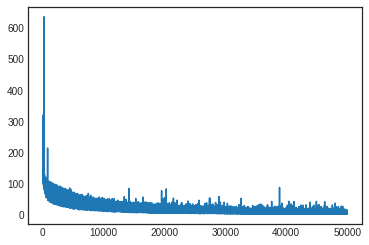

----
 enc. He a folilition spreads iant beppersing the publining many travels Connit the patient there a fur trian in other countries, the kind of coronavirus infection, do the same things youndmamt lab nev 
----
iter 50000, loss 6.221061


In [67]:
iter = 50100
while iter > 0:
  # Reset
  if pointer + Time_steps >= len(data) or iteration == 0:
      g_h_prev = np.zeros((Hidden_Layer_size, 1))
      g_C_prev = np.zeros((Hidden_Layer_size, 1))
      pointer = 0


  inputs = ([char_to_idx[ch] 
              for ch in data[pointer: pointer + Time_steps]])
  targets = ([char_to_idx[ch] 
              for ch in data[pointer + 1: pointer + Time_steps + 1]])

  loss, g_h_prev, g_C_prev = \
      forward_backward(inputs, targets, g_h_prev, g_C_prev)
  smooth_loss = smooth_loss * 0.999 + loss * 0.001

  # Print every hundred steps
  if iteration % 100 == 0:
      update_status(inputs, g_h_prev, g_C_prev)

  update_paramters()

  plot_iter = np.append(plot_iter, [iteration])
  plot_loss = np.append(plot_loss, [loss])

  pointer += Time_steps
  iteration += 1
  iter = iter -1

# Quiz Question 7. 

Run the above code for 50000 iterations making sure that you have 100 hidden layers and time_steps is 40. What is the loss value you're seeing?